# Unigram Mixture model


##### The model :
Recall the unigram mixture model in plate notations :
<img src="img/unigram_mixture_new.png" alt="unigram mixture" width="200"/>

To sample from this model :

First, we have to sample the topic of a document as a one-hot vector, from a multinomial of size $K$.
- $z \sim \mathcal{M}(1, (\pi_1, \dots, \pi_K)), z\in\{0, 1\}^K$
- $p(z)=\prod_{k=1}^K\pi_k^{z_k}$

Once the topic $z^{(i)}$ is selected for document $i$, we can the $N$ words of each documents from a multinomial of size $d$, which is the vocabulary size.
- $w^{(i)}_n~|~\{z^{(i)}_k = 1\} \sim \mathcal{M}(1, (b_{1k},\dots,b_{dk}))$



Finally :
$\displaystyle{p(w^{(i)}, z^{(i)}) = \prod_{k=1}^K \Big[\pi_k^{z_k}\prod_{j=1}^d \prod_{n=1}^{N}b_{jk}^{w^{(i)}_{n,j}z_k}\Big]}$

### Question 0:
Let $x^{(i)}_j=\sum_{n=1}^N w_{nj}^{(i)}$. What is the distribution of $x^{(i)}~|~\{z^{(i)}_k = 1\}$ ?

In the rest of the session, we will work with word counts $x^{(i)}$ as done in the slides.

$p(x^{(i)} / z^{(i)}_k = 1)=  C \prod_{j=1}^{d}b_{(jk)}^{x^{(i)}_{j}}$

### Question 1:
Sample $M=400$ documents of $N=30$ words from the given $\pi$ and $b$ in the next cell. We have $d=3$ words, but $K=6$ topics.
Complete the function _gen_\__corpus_ below that takes all the required parameters as input, and returns a $(M,d)$ array containg the $x^{(i)}$, as well as an $(M,)$ array containing the topics associated with these documents.

In [56]:
import numpy as np

n_docs = 400
doc_length = 30
n_topics = 6
n_tokens = 3 # size of the dictionary

topic_proba = np.array([1./n_topics] * n_topics)
word_proba = np.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8],
    [0.45, 0.45, 0.1],
    [0.1, 0.45, 0.45],
    [0.45, 0.1, 0.45]
])


# WARNING: word_proba and corpus are transposed versions of B and X seen in class.
def gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba):
    """
    n_docs: number of documents, S
    n_topics: number of topics, K
    doc_length: number of words per documents, N
    topic_proba: (K,) array containing the pi_k
    word_proba: (K, d) array containing the b_{k,j}.
    
    returns: 
    corpus: (M, K) array containing the word counts for each documents
    topics: (M, K) array containing one-hot vectors for the topic of each document
    """
    corpus = np.empty((n_docs, n_tokens))
    topics = np.random.multinomial(1, topic_proba,n_docs)# TODO: sample the topic of each documents

    # For each document, sample the word counts x corresponding to the sampled topic
    for doc_id, topic in enumerate(topics):
        # topic is a one-hot vector, use `where` to find where the 1 is
        topic_id = np.where(topic)[0][0]
        corpus[doc_id] = np.random.multinomial(doc_length, word_proba[topic_id]) # TODO: Sample the count of words according to topic_id.
    return corpus, topics

corpus, topics = gen_corpus(n_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)

### Visualizing the data :
In the next cell, we propose a visualization of this corpus. We will use the three vertices of a triangle to represent our three tokens. A document will be represented as a convex combination of the three vertices. We will color each document according to their topic (red, green, blue and black).
Finally, each row in $b$ giving the token probability given the topic will also be visualized.

### Question 2:
Run the next cell to visualize the dataset. Explain what is shown in the obtained figure.

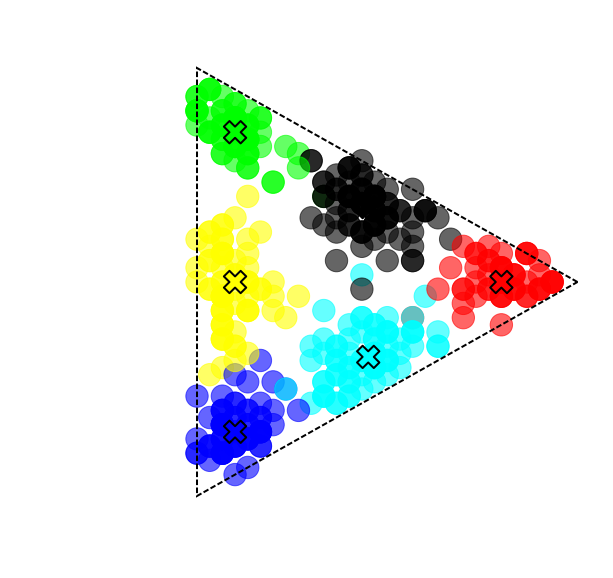

In [57]:
%matplotlib inline
import math

from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Compute the triangle vertices using complex roots of 1
vertex_ids = np.array(range(n_tokens))
vertices = np.vstack([
    np.cos(2 * math.pi * vertex_ids / n_tokens),
    np.sin(2 * math.pi * vertex_ids / n_tokens)]
).T

# Plot the triangle
fig, ax = plt.subplots(figsize=(10, 10))
polygon = Polygon(vertices, fill=False, linewidth=2, linestyle='--')
ax.add_patch(polygon)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# Compute a S x 2 array containing documents as linear combination of our vertices

linear_combinations = (corpus / np.sum(corpus, axis=1)[:, None]) @ vertices  
colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 0, 0], [1, 1, 0], [0, 1, 1]])

plt.scatter(
    linear_combinations[:, 0], linear_combinations[:, 1], c=np.array(topics) @ colors,
    marker='o', s=500, alpha=0.6
)

centers = word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

plt.axis('off')

plt.show()

We observe documents $(x^{(i)})_{i=1..M}$, and apply EM for $t=1\dots T$.


##### E-Step:
- $\displaystyle{p(z^{(i)}_k=1~|~x^{(i)};b^{(t-1)};\pi^{(t-1)}) = \frac{\pi^{(t-1)}_k \prod_{j=1}^d(b_{jk}^{(t-1)})^{x_j}}{\sum_{k'=1}^K\pi^{(t-1)}_{k'}\prod_{j=1}^d(b_{jk'}^{(t-1)})^{x_j}}}$
- $q^{(t)}_{ik} = \mathbb{E}[z_k~|~x^{(i)};b^{(t)};\pi^{(t)}]$


##### M-Step:
- $\displaystyle{b_{jk}^{(t)} = \frac{\sum_{i}x_j^{(i)}q_{ik}^{(t)}}{\sum_{i,j'}x_{j'}^{(i)}q_{ik}^{(t)}}}$ and $\displaystyle{\pi_{k}^{(t)} = \frac{\sum_{i}q_{ik}^{(t)}}{\sum_{i,k'}q_{ik'}^{(t)}}}$


### Question 3:
1. Re-derive the above formula for $b^{(t)}_{jk}$ starting from the expected complete log-likelihood :
$$\mathbb{E}_{q_i^{(t)}}[\log(p(X, Z;b,\pi)]=\sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) + \sum_{i,k}q_{ik}^{(t)}\log(\pi_k) + \tilde{c}$$
2. It could happen in the computation of $q_{ik}^{(t)}$ that both numerator and denominator are very small. To avoid any numerical underflows, we will compute $\log(q_{ik}^{(t)})$ from the logarithms of both numerator and denominator. We use the function logsumexp defined below to compute the denominator from the logarithms of the terms in the sum. Explain why we factored out the maximal value on each row ? 
3. Write code for logsumexp which computes $\log(\sum_i\exp(x_i))$, beware of (2.). Write a test that shows the implementation works as expected. How can we use this function in the E step ?
4. Fill in the code for the E and M steps.

## Explain why we factored out the maximal value on each row ? : 
    
$Answer$: 
Explanaition: We factorize out the maximal value on each row to apply the lagrange multiplier and maximize the following quantity: $\sum_{i,j,k}x_j^{(i)}q_{ik}^{(t)}\log(b_{jk}) - \lambda(\sum_{j}b_{jk} -1)$

In [58]:
def logsumexp(x):
    """
    x: a (n, m) array.
    return: log(sum(exp(x_i,:))) for all i, avoiding numerical underflow
    """
    # select the maximum on each row
    max_per_line = x.max(-1)
    res = max_per_line + np.log(np.sum(np.exp(x-max_per_line[:,None]),-1))
    return res

# test that our function does what it should on simple inputs
x = np.array([[1, 2, 3], [2, 2, 2]]) 
print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1)))

# write a test case in which the basic method overflows and yours doesn't
x = np.array([[1e-1000,1e-1001,1e-1002], [1e-2000, 1e-2001,1e-2002]]) 
print(logsumexp(x), np.log(np.sum(np.exp(x), axis=1))) # 


def E_step(corpus, learned_topic_proba, learned_word_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_topic_proba : (n_topics, n_token) array containing the probability of each word for each topic
    returns : doc_topic_proba : (S, n_topicdlhkfiidgninkhvulrjvurlvhrdekcur) the q_ik
    """
    # TODO: complete
    A = np.log(learned_topic_proba) + corpus @ np.log(learned_word_proba.T)
    A1 = logsumexp(A)[:,None]
    C = A - A1
    return np.exp(C)

def M_step(corpus, doc_topic_probas):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing q_ik computed in the E-step
    """
    B = (corpus.T @ doc_topic_probas)/np.sum(corpus.T @ doc_topic_probas,axis = 0)                
    Pi = np.sum(doc_topic_probas,axis = 0)/ np.sum(doc_topic_probas)#pass  # TODO: complete
    return Pi, B.T

[3.40760596 3.09861229] [3.40760596 3.09861229]
[1.09861229 1.09861229] [1.09861229 1.09861229]


## How can we use this function in the E step ?
$Answer$:  We can use this function at E step by ceating the variable who is our denominatir and call the fucntion logsumexp() of all the denominator.

### Log-Likelihood
It is convenient to visualize the evolution of the marginal log-likelihood of our parameters during training to make sure it is being maximized.

### Question 4:
1. Prove mathematically that the marginal log-likelihood of the parameters during EM increases at each iteration.
2. Implement the computation of the log-likelihood in the next cell. `log_likelihood_qik` will be used later in the session. Hint : `log_multinomial(corpus)` computes $\tilde{c}$

In [59]:
from scipy.special import gammaln
def log_multinomial(params):
    return gammaln(np.sum(params, axis=1) + 1) - np.sum(gammaln(params + 1), axis=1)

def log_likelihood_q_ik(corpus, doc_topic_probas, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    doc_topic_probas : (S, n_topics) array containing E_q[z] computed in the E-step
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    first_term = corpus @ np.log(learned_word_proba.T)
    first_term[np.isnan(first_term)] = 0
    first_term *= doc_topic_probas
    
    second_term = doc_topic_probas @ np.log(learned_topic_proba)[:, None]
    entropy = np.log(doc_topic_probas) * doc_topic_probas
    entropy[np.isnan(entropy)] = 0
    return (np.sum(first_term) + np.sum(second_term) - np.sum(entropy) + np.sum(log_multinomial(corpus))) / corpus.shape[0]

def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    A2 = np.sum(logsumexp( corpus @ np.log(learned_word_proba).T + np.log(learned_topic_proba)))
    LK = np.sum(log_multinomial(corpus)) + A2
    return (LK / corpus.shape[0])  # TODO: complete

### Running EM :
We can now run the Expectation-Maximization algorithm on our corpus.
We will initialize the algorithm by setting $\pi_k = 1/K$.
For $b_{k}$, we use the proportions of random documents.
Then we run the algorithm for a few iterations.

Upon completion, we plot the log likelihood curve for training and validation data.

### Question 5:
- Fill the TODOs in the code, and comment the results when asked.

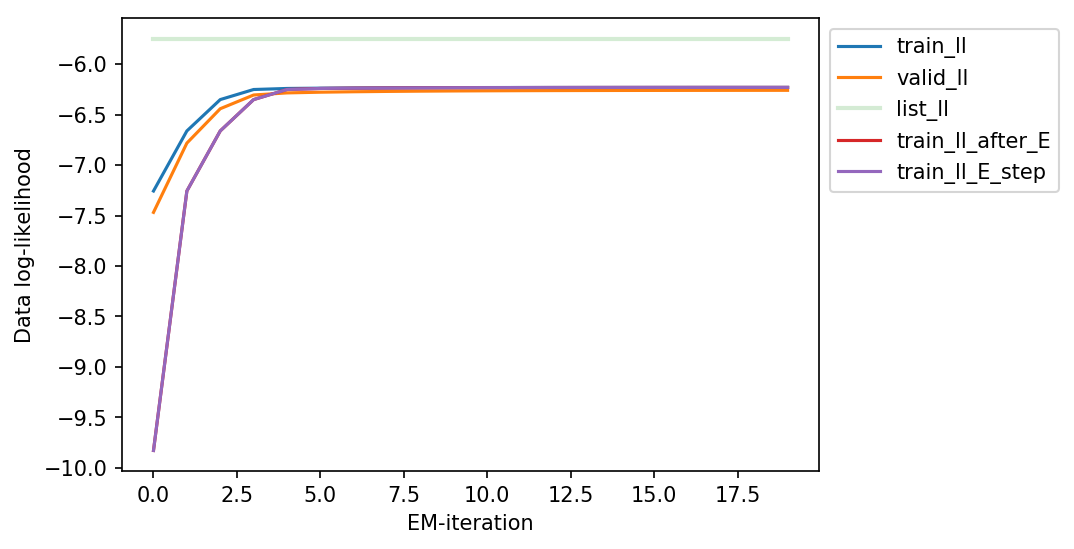

In [60]:

valid_corpus, valid_topics = gen_corpus(1000, n_topics, n_tokens, doc_length, topic_proba, word_proba)

n_iter = 20
n_learned_topics = 6

# We nitialize the learned parameter
# uniform topic proba
learned_topic_proba = np.ones((n_learned_topics,)) / n_learned_topics

# word proba taken from random documents + some constant to avoid zeroes
learned_word_proba = corpus[np.random.permutation(n_docs)[:n_learned_topics]] + 1e-3
learned_word_proba = learned_word_proba / np.sum(learned_word_proba, axis=1)[:, None]

plt.figure(dpi=150)
train_ll = []
train_ll_after_E = []
train_ll_E_step = []
valid_ll = []
for i in range(n_iter):
    # TODO: step of the EM algorithm
    doc_topic_probas = E_step(corpus,learned_topic_proba,learned_word_proba)
    
    # TODO: After E-step call log_likelihood_q_ik on the training data and append this value to train_ll_E_step
    v1 = log_likelihood_q_ik(corpus, doc_topic_probas, learned_word_proba, learned_topic_proba)
    train_ll_E_step.append(v1)
    
    # TODO: After E-step, also call log_likelihood on the training data and  append this value to train_ll_after_E
    v2 = log_likelihood(corpus, learned_word_proba, learned_topic_proba)
    train_ll_after_E.append(v2)
    #print(np.abs(v2-v1)<1e-5)
    
    # TODO: After M-step compute the log-likelihoods and append these values to train_ll and valid_ll
    learned_topic_proba, learned_word_proba =  M_step(corpus, doc_topic_probas)
    valid_ll.append(log_likelihood(valid_corpus, learned_word_proba, learned_topic_proba))
    train_ll.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))
    
    # This assert checks that each multinomial for learned_word_proba sums to 1
    assert np.all(np.abs(np.sum(learned_word_proba, axis=1) - 1) < 1e-10)
    # This assert checks that learned_topic_proba sums to 1
    assert np.all(np.abs(np.sum(learned_topic_proba) - 1) < 1e-10)
    
# compute valid log-likelihood for the true parameters of the model
ll = log_likelihood(valid_corpus,word_proba,topic_proba)
list_ll = [ll]*n_iter

# TODO: plot train_ll, valid_ll, and valid log-likelihood for true parameters. comment
plt.plot(train_ll,label='train_ll')
plt.plot(valid_ll, label='valid_ll')
plt.plot(list_ll, label='list_ll', linewidth = 2, alpha =0.2)
 
# TODO: plot train_ll, train_ll_E_step, train_ll_after_E. comment
plt.plot(train_ll_after_E, label='train_ll_after_E')
plt.plot(train_ll_E_step, label='train_ll_E_step')

    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

## $Answer$
- Fill the TODOs in the code, and comment the results when asked.
A graph that shows the relationship between the 'EM- iteration' and the difference in Data log-likelihood.The complete Data log-likelihood increases after every EM-iteration. This means that every new iteration  finds a "better" estimate.

### Question 6:
Plot the learned word_proba along the dataset and original word_probas. Rerun the code with several different random initializations, comment.

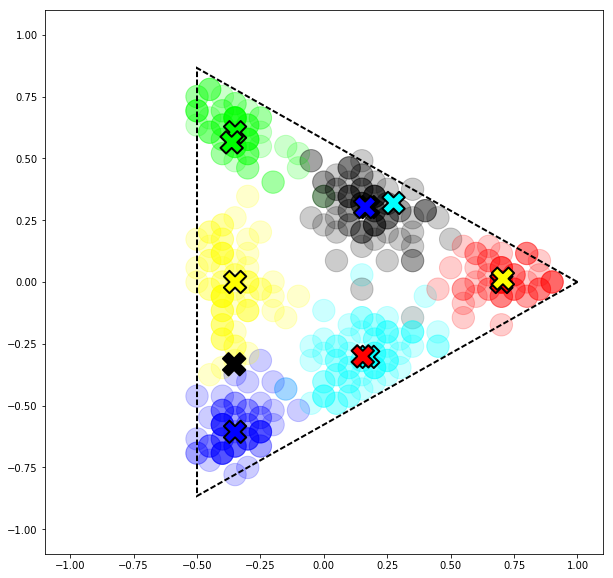

In [61]:
# Plot the triangle
fig, ax = plt.subplots(figsize=(10, 10))
polygon = Polygon(vertices, fill=False, linewidth=2, linestyle='--')
ax.add_patch(polygon)
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

# Compute a S x 2 array containing documents as linear combination of our vertices
linear_combinations = (corpus / np.sum(corpus, axis=1)[:, None]) @ vertices  

plt.scatter(
    linear_combinations[:, 0], linear_combinations[:, 1], c=np.array(topics) @ colors,
    marker='o', s=500, alpha=0.2
)

# plot real word_proba

centers = word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

# TODO:  plot the learned word_proba.
centers = learned_word_proba @ vertices

plt.scatter(
    centers[:, 0], centers[:, 1], c=colors,
    marker='X', s=500, alpha=1, edgecolor=(0, 0, 0, 1), linewidths=2
)

plt.show()

# $Comment !$
#This figure show the plot of the learned  word_prob and the original word_proba. We remarque that when we do a good initialization, the model learn very well and we observe that the center are superimpose.

### Larger synthetic dataset

Now, we will generate a more realistic synthetic dataset. We will have $1000$ documents of $200$ words each, $10$ topics and $50$ different tokens.
We will randomly generate the parameters of our generative model with uniform <em>topic_proba</em> and <em>word_proba</em> coming from a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) distribution with all parameters equal to $\alpha=0.5$.

### Question 6:
- How can we determine the right number of topics to model this data ?
- Implement this idea in the following cell.

#$Answer$
- How can we determine the right number of topics to model this data ?

We now propose a model selection approach for topic modeling. We intitialize our learning, for every topic we initialize the learned parameter and for every iteration we compute E-step and M-step. After, we append the log-likelihood and we plot the it foe the argmax of the training the get the best numer of topic.

In [73]:
n_train_docs = 100
n_valid_docs = 1000
doc_length = 200
n_topics = 10
n_tokens = 50
alpha = 0.5


def gen_bigger_corpus(
    n_train_docs, n_valid_docs, doc_length,
    n_topics, n_tokens, alpha
):
    topic_proba = np.array([1./n_topics] * n_topics)
    word_proba = np.random.dirichlet([alpha] * n_tokens, size=n_topics)

    corpus, topics = gen_corpus(n_train_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    valid_corpus, valid_topics = gen_corpus(n_valid_docs, n_topics, n_tokens, doc_length, topic_proba, word_proba)
    
    # This is called smoothing : https://en.wikipedia.org/wiki/Smoothing
    corpus += 1e-5
    valid_corpus += 1e-5
    
    
    return topic_proba, word_proba, corpus, valid_corpus

# TODO: Implement your method here.

# Use the previous function to generate your dataset
topic_proba, word_proba, corpus, valid_corpus = gen_bigger_corpus(n_train_docs, n_valid_docs,doc_length, n_topics, n_tokens, alpha)

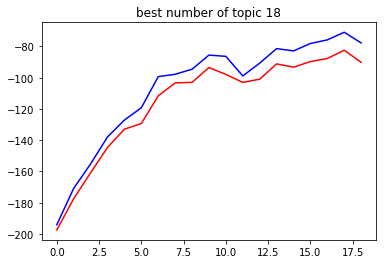

In [102]:
n_learned_topics = range(1, 20)
train_ll=[]
valid_ll = []
for n_topics in n_learned_topics:
    
    #We nitialize the learned parameter
    #uniform topic proba
    learned_topic_proba = np.ones((n_topics,)) / n_topics

    #word proba taken from random documents + some constant to avoid zeroes
    learned_word_proba = corpus[np.random.permutation(n_train_docs)[:n_topics]] + 1e-3
    learned_word_proba = learned_word_proba / np.sum(learned_word_proba, axis=1)[:, None]


    for i in range(n_iter):
        #TODO: step of the EM algorithm
        doc_topic_probas = E_step(corpus,learned_topic_proba,learned_word_proba)

        #TODO: After M-step compute the log-likelihoods and append these values to train_ll and valid_ll
        learned_topic_proba, learned_word_proba =  M_step(corpus, doc_topic_probas)
    valid_ll.append(log_likelihood(valid_corpus, learned_word_proba, learned_topic_proba))
    train_ll.append(log_likelihood(corpus, learned_word_proba, learned_topic_proba))

    #print(n_learned_topics[np.argmax(train_ll)])
    
    
plt.plot(train_ll, label='train_ll', c= 'b')
plt.plot(valid_ll,label='valid_ll', c= 'red')
plt.title('best number of topic {}'.format(np.argmax(train_ll)+1))

# Application to Text
This model is well suited to represent text. In the following, we will apply our EM algorithm to discover topics in the _newsgroup 20_ corpus.

As is standard in Natural Language Processing, we will first apply a few pre-processing steps to the corpus as described [here](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925).

Make sure you have installed the following libraries into your conda environment : 
- gensim
- nltk
- scikit-learn

First, we download the dataset, and wordnet.

In [80]:
import gensim
import nltk

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.datasets import fetch_20newsgroups

newsgroups = {
    'train': fetch_20newsgroups(subset='train', shuffle = True),
    'test': fetch_20newsgroups(subset='test', shuffle = True)
}
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/kenne/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Preprocessing :
We use the same pre-processing as in the blog-post :
- **Tokenization** : Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All **stopwords** are removed.
- Words are **lemmatized** - third person is changed to first person, all verbs are changed into present tense
- Words are **stemmed** - words are reduced to their root form.

In [81]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

preprocess("The quick brown fox jumped over the lazy dogs.")

['quick', 'brown', 'jump', 'lazi', 'dog']

### Dictionary making:
Each unique element in the output of _preprocess_ is a token. We need to convert these into unique ids to run our algorithm. This is called building a **dictionary**. The library _gensim_ has a helper function to help us do this.

### Question 7:
- Why is all this preprocessing useful ?

## $ Answer$ 

This preprocessing useful beacause is a major and essential stage whose main goal is to obtain final data sets that can be considered correct and useful for the  algorithms.

In [82]:
processed_docs = {s: [] for s in ['train', 'test']}
# This may take a while. We are processing the entire dataset.
for s in ['train', 'test']:
    for doc in newsgroups[s].data:
        processed_docs[s].append(preprocess(doc))
    
dictionary = gensim.corpora.Dictionary(processed_docs['train'])
# print(f"{len(dictionary)} unique tokens before filtering")
print("{} unique tokens before filtering".format(len(dictionary)))
dictionary.filter_extremes(no_below=15, no_above=0.1)
# print(f"{len(dictionary)} unique tokens after filtering")
print("{} unique tokens after filtering".format(len(dictionary)))

61411 unique tokens before filtering
6535 unique tokens after filtering


In [83]:
# transform our corpus of text to lists of counts of tokens
bow_corpus = {
    s: [dictionary.doc2bow(doc) for doc in processed_docs[s]]
    for s in ['train', 'test']
}

n_tokens = len(dictionary)
text_corpus = {'train': None, 'test': None}
for s in text_corpus.keys():
    n_docs = len(processed_docs[s])
    text_corpus[s] = np.zeros((n_docs, n_tokens), dtype='int32')
    for d, bow in enumerate(bow_corpus[s]):
        for (id, value) in bow:
            text_corpus[s][d, id] = value

### Model learning
Now that the dataset is ready run EM on it, using $5$ topics. Since the dataset is bigger, this could take some time.

/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in multiply
/home/kenne/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


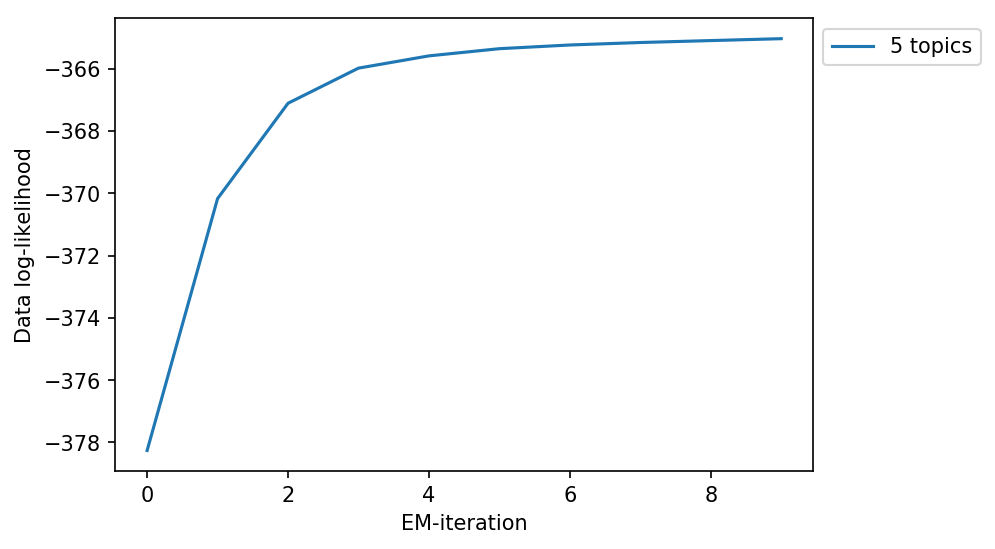

In [84]:
# New E_step using bag of words rather than dense count arrays
def E_step_sparse(corpus, learned_topic_proba, learned_word_proba):
    n_topics = learned_topic_proba.shape[0]
    res = np.zeros((len(corpus), n_topics))
    for d, tuples in enumerate(corpus):
        maxi = np.finfo('float64').min
        for topic in range(n_topics):
            cur = np.log(learned_topic_proba[topic])
            for tok_id, v in tuples:
                tok_prob = learned_word_proba[topic, tok_id]
                cur += np.log(tok_prob) * v
            res[d, topic] = cur
            maxi = max(maxi, cur)
        total = 0
        for topic in range(n_topics):
            total += np.exp(res[d, topic] - maxi)
            res[d, topic] = np.exp(res[d, topic] - maxi)
        res[d, :] /= total

    return res

# New log_likelihood to deal with NaNs
def log_likelihood(corpus, learned_word_proba, learned_topic_proba):
    """
    corpus : (S, n_tokens) array containing the counts of words in each document
    learned_topic_proba : (n_topics, ) array containing the probability of each topic
    learned_word_proba : (n_topics, n_token) array containing the probability of each word for each topic
    """
    all_products = np.log(learned_word_proba[None, :, :]) * corpus[:, None, :]
    all_products[np.isnan(all_products)] = 0
    A = np.sum(all_products, axis=2) + np.log(learned_topic_proba)[None, :] + log_multinomial(corpus)[:, None]
    return np.mean(logsumexp(A))

n_iter = 10
n_topics = 5
n_docs = len(bow_corpus['train'])

learned_topic_proba = np.ones((n_topics,)) / n_topics
learned_word_proba = np.empty((n_topics, n_tokens), dtype='float32')
# initialize topic probabilities with random documents
permutation = np.random.permutation(n_docs)
batch_size = n_docs // n_topics
for t in range(n_topics):
    stats = np.sum(text_corpus['train'][permutation[t * batch_size: (t+1) * batch_size]], axis=0)
    learned_word_proba[t] = stats / np.sum(stats)

train_ll = []
valid_ll = []
for i in range(n_iter):
    # E-step
    doc_topic_probas = E_step_sparse(bow_corpus['train'], learned_topic_proba, learned_word_proba)

    # E-step for valid
    valid_topic_probas = E_step_sparse(bow_corpus['test'], learned_topic_proba, learned_word_proba)

    # M-step
    learned_topic_proba, learned_word_proba = M_step(text_corpus['train'], doc_topic_probas)

    train_ll.append(log_likelihood(text_corpus['train'], learned_word_proba, learned_topic_proba))    
    valid_ll.append(log_likelihood(text_corpus['test'], learned_word_proba, learned_topic_proba))
    
plt.figure(dpi=150)
#p, = plt.plot(range(len(train_ll)), train_ll, '-', label=f"{n_topics} topics")
p, = plt.plot(range(len(train_ll)), train_ll, '-', label="{} topics".format(n_topics))
plt.plot(range(len(valid_ll)), valid_ll, '--', c=p.get_color())
    
plt.xlabel("EM-iteration")
plt.ylabel("Data log-likelihood")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()


### Visualizing the topics

Now that we've run EM, we can print the most frequent terms associated to each topics.

In [85]:
print(learned_topic_proba)
for t in range(n_topics):
    most_frequent = np.argsort(learned_word_proba[t])[-10:]
#     print(f"------- Topic {t} ------")
    print("------- Topic {t} ------")
    for w in most_frequent:
#         print(f"\t -- {dictionary[int(w)]}")
        print("\t -- {dictionary[int(w)]}")

[0.16254758 0.15436737 0.16990569 0.17239758 0.34078178]
------- Topic {t} ------
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
------- Topic {t} ------
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
------- Topic {t} ------
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
------- Topic {t} ------
	 -- {dictionary[int(w)]}
	 -- {dictionary[int(w)]}
	 -- {dicti

### Perplexity
The [perplexity](https://en.wikipedia.org/wiki/Perplexity) of a model $q$ on a test sample $(x_s)$ is given by :
$$2^{-\frac{1}{S}\sum_{s=1}^S\log_2(q(x_s))}$$

### Question 8 :
Explain why this quantity is called perplexity.



## $Answer$
This quantity is calles perplexity because it A measure of language model performance based on average probability can be developed within the field of information theory. In other words, it is a measurement of how well a probability distribution or probability model predicts a sample in information theory.

### Bonus Questions :
- In the code implemented for question 6, what happens when we increase the number of documents in the training set ? Comment.
- What can you notice regarding the computations done in the E-M algorithm for this practical session ? How would you implement this algorithm in a distributed fashion ?

## Answer
- What happens when we increase the number of documents in the training set ? Comment.
When we increase the number of documents in the training set, we avoid overfitting because, when the number of document is small we have overffiting.

## Answer
- What can you notice regarding the computations done in the E-M algorithm for this practical session.
The complete data log-likelihood increases after every EM-iteration. Comparing the true density function with the estimated one.

## Answer
- How would you implement this algorithm in a distributed fashion ?
We implement by estimating some unknown parameters from the given data in the presence of some unobserved or hidden variables.